# Evaluation metrics of GPT-4o annotations

## Imports

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

## Paths

In [2]:
# Cell 2: Data paths and configuration
# Base path
BASE_PATH = Path("../results")
RESULTS_PATH = BASE_PATH / "annotations/llm/openAI/gpt-4o"
EVAL_RESULTS_FILE = BASE_PATH / "evaluations/evaluation_metrics_calculation_input.csv"

EVAL_COLUMNS = [
    'Qualifier_Evaluation',
    'Laterality_Evaluation',
    'Presence_Evaluation',
    'PrimarySecondary_Evaluation',
    'Experiencer_Evaluation',
    'TreatmentStage_Evaluation',
    'SNOMED_CT_Evaluation'
]

# Clinical categories (qualifiers)
CLINICAL_CATEGORIES = [
    'sociodemographics',
    'signs',
    'symptoms',
    'diagnoses',
    'procedures',
    'treatments',
    'risk factors',
    'test results'
]

In [3]:
EVAL_RESULTS_FILE

PosixPath('../results/evaluations/evaluation_metrics_calculation_input.csv')

In [4]:
test_df = pd.read_csv(EVAL_RESULTS_FILE)
test_df

,Row ID,Text,Context,Qualifier_Evaluation,Qualifier_Correction,Laterality_Evaluation,Laterality_Correction,Presence_Evaluation,Presence_Correction,PrimarySecondary_Evaluation,...,SNOMED_CT_Correction,Notes,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Letter 0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,adenoidectomy and tonsillectomy and lingual fr...,adenoidectomy and tonsillectomy and lingual fr...,TP,NaN,TN,NaN,TP,NaN,TP,...,119954001; 173422009; 7001008,"for lingual frenulectomy, the snomed code 7001...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,chronic adenotonsillitis,chronic adenotonsillitis and ankyloglossia.,TP,NaN,TN,NaN,TP,NaN,TP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,ankyloglossia,chronic adenotonsillitis and ankyloglossia.,TP,NaN,TN,NaN,TP,NaN,TP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,general endotracheal,anesthesia: general endotracheal.,TP,NaN,TN,NaN,TP,NaN,FN,...,266802007,Should anasesthesia be classified as 'primary'...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,14,corrective saccades,vestibulocular reflex [halmagyi test]: showed ...,TP,NaN,TN,NaN,TP,NaN,FN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2240,15,decompensated vestibular hypofunction,vestibulocular reflex [halmagyi test]: showed ...,TP,NaN,TN,NaN,TP,NaN,TP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2241,16,vestibular rehabilitation exercises,the patient was advised to continue her vestib...,TP,NaN,TN,NaN,TP,NaN,TP,...,23399008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2242,17,betahistine,the patient was advised to continue her vestib...,TP,NaN,TN,NaN,TP,NaN,TP,...,418067008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Cell 3: Load and preprocess the evaluation results
def load_evaluation_results(filepath):
    """Load the evaluation results CSV with proper handling of the structure"""
    # Read the CSV
    df = pd.read_csv(filepath)

    # The CSV has a specific structure with letter headers
    # We need to identify where each letter starts
    letter_rows = df[df['Row ID'].str.contains('Letter', na=False)].index.tolist()

    # Process each letter's data
    all_evaluations = []

    for i in range(len(letter_rows)):
        # Get letter ID
        letter_id = df.iloc[letter_rows[i]]['Row ID']

        # Get the data for this letter
        if i < len(letter_rows) - 1:
            letter_data = df.iloc[letter_rows[i]+2:letter_rows[i+1]-1].copy()
        else:
            letter_data = df.iloc[letter_rows[i]+2:].copy()

        # Skip if empty
        if letter_data.empty or letter_data['Row ID'].isna().all():
            continue

        # Add letter ID to each row
        letter_data['Letter_ID'] = letter_id
        letter_data = letter_data[letter_data['Row ID'].notna()]

        all_evaluations.append(letter_data)

    # Combine all letters
    if all_evaluations:
        eval_df = pd.concat(all_evaluations, ignore_index=True)
        return eval_df
    else:
        return pd.DataFrame()

# Load the evaluation data
eval_df = load_evaluation_results(EVAL_RESULTS_FILE)
print(f"Loaded {len(eval_df)} evaluation rows from {eval_df['Letter_ID'].nunique()} letters")

Loaded 1953 evaluation rows from 97 letters


In [6]:
eval_df.head()

,Row ID,Text,Context,Qualifier_Evaluation,Qualifier_Correction,Laterality_Evaluation,Laterality_Correction,Presence_Evaluation,Presence_Correction,PrimarySecondary_Evaluation,...,Notes,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Letter_ID
0,2,chronic adenotonsillitis,chronic adenotonsillitis and ankyloglossia.,TP,NaN,TN,NaN,TP,NaN,TP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter 0000
1,3,ankyloglossia,chronic adenotonsillitis and ankyloglossia.,TP,NaN,TN,NaN,TP,NaN,TP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter 0000
2,4,general endotracheal,anesthesia: general endotracheal.,TP,NaN,TN,NaN,TP,NaN,FN,...,Should anasesthesia be classified as 'primary'...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter 0000
3,5,tonsil and adenoid tissue,findings/specimen: tonsil and adenoid tissue.,TP,NaN,TN,NaN,TP,NaN,TN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter 0000
4,6,none,complications: none.,TP,NaN,TN,NaN,TN,NaN,TN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter 0000


In [7]:
eval_df.shape

(1953, 27)

In [8]:
# Cell 4: Load and match qualifier information from final_output.csv files
def load_qualifier_mappings(base_path):
    """Load qualifier information from final_output.csv files in each letter directory"""
    qualifier_mappings = {}

    # Find all letter directories
    letter_dirs = sorted([d for d in os.listdir(base_path) if d.startswith('letter_')])

    for letter_dir in letter_dirs:
        if letter_dir == 'letter_0080':
            continue  # Skip letter_0080 as is training
        final_output_path = base_path / letter_dir / 'final_output.csv'

        if final_output_path.exists():
            # Load the final output
            final_df = pd.read_csv(final_output_path)

            # Create a mapping of text to qualifier for this letter
            letter_id = f"Letter {letter_dir.split('_')[1]}"
            qualifier_mappings[letter_id] = {}

            for _, row in final_df.iterrows():
                text = row['text'].strip().lower() if pd.notna(row['text']) else ''
                qualifier = row['qualifier'] if pd.notna(row['qualifier']) else ''
                if text and qualifier:
                    qualifier_mappings[letter_id][text] = qualifier

    return qualifier_mappings

# Load qualifier mappings
qualifier_mappings = load_qualifier_mappings(RESULTS_PATH)
print(f"Loaded qualifier mappings for {len(qualifier_mappings)} letters")

Loaded qualifier mappings for 98 letters


In [9]:
# Cell 13: Fix letter ID formatting inconsistency
def standardize_letter_id(letter_id):
    """Standardize letter ID format to always have 4 digits"""
    if pd.isna(letter_id):
        return letter_id

    # Extract the numeric part
    parts = letter_id.split()
    if len(parts) == 2 and parts[0] == 'Letter':
        try:
            # Convert to int and format with leading zeros
            num = int(parts[1])
            return f"Letter {num:04d}"
        except ValueError:
            return letter_id
    return letter_id

# Cell 14: Apply standardization to both datasets
# Standardize letter IDs in evaluation dataframe
eval_df['Letter_ID'] = eval_df['Letter_ID'].apply(standardize_letter_id)

# Standardize letter IDs in qualifier mappings
standardized_qualifier_mappings = {}
for letter_id, mappings in qualifier_mappings.items():
    standardized_id = standardize_letter_id(letter_id)
    standardized_qualifier_mappings[standardized_id] = mappings

# Check the result
print("Standardized Letter IDs in eval_df:")
print(eval_df['Letter_ID'].unique()[:10])
print("\nStandardized Letter IDs in qualifier mappings:")
print(list(standardized_qualifier_mappings.keys())[:10])

Standardized Letter IDs in eval_df:
['Letter 0000' 'Letter 0001' 'Letter 0002' 'Letter 0003' 'Letter 0004'
 'Letter 0005' 'Letter 0006' 'Letter 0007' 'Letter 0008' 'Letter 0009']

Standardized Letter IDs in qualifier mappings:
['Letter 0000', 'Letter 0001', 'Letter 0002', 'Letter 0003', 'Letter 0004', 'Letter 0005', 'Letter 0006', 'Letter 0007', 'Letter 0008', 'Letter 0009']


In [10]:
# Cell 5: Match qualifiers to evaluation data
def match_qualifiers_to_evaluations(eval_df, qualifier_mappings):
    """Match the qualifier information to each evaluation row"""
    eval_df = eval_df.copy()
    eval_df['qualifier'] = None

    for idx, row in eval_df.iterrows():
        letter_id = row['Letter_ID']
        text = row['Text'].strip().lower() if pd.notna(row['Text']) else ''

        if letter_id in qualifier_mappings and text in qualifier_mappings[letter_id]:
            eval_df.at[idx, 'qualifier'] = qualifier_mappings[letter_id][text]

    return eval_df

# Match qualifiers
eval_df = match_qualifiers_to_evaluations(eval_df, standardized_qualifier_mappings)

# Check how many matches we got
print(f"Successfully matched qualifiers for {eval_df['qualifier'].notna().sum()} out of {len(eval_df)} rows")
print(f"\nQualifier distribution:")
print(eval_df['qualifier'].value_counts())

Successfully matched qualifiers for 1942 out of 1953 rows

Qualifier distribution:
qualifier
signs                524
diagnoses            309
procedures           297
treatments           267
symptoms             214
test results         143
risk factors         112
sociodemographics     76
Name: count, dtype: int64


In [11]:
# Cell 9: Diagnose missing matches
def diagnose_missing_matches(eval_df, qualifier_mappings):
    """Identify which letters and texts are not matching"""

    # First, let's see the match rate by letter
    match_stats = []

    for letter_id in eval_df['Letter_ID'].unique():
        letter_data = eval_df[eval_df['Letter_ID'] == letter_id]
        total_rows = len(letter_data)
        matched_rows = letter_data['qualifier'].notna().sum()
        match_rate = matched_rows / total_rows if total_rows > 0 else 0

        match_stats.append({
            'Letter_ID': letter_id,
            'Total_Rows': total_rows,
            'Matched_Rows': matched_rows,
            'Unmatched_Rows': total_rows - matched_rows,
            'Match_Rate': match_rate
        })

    match_stats_df = pd.DataFrame(match_stats)

    print("Match Statistics by Letter:")
    print(match_stats_df.sort_values('Match_Rate'))

    # Now let's look at some specific unmatched examples
    print("\n" + "="*80)
    print("UNMATCHED EXAMPLES:")
    print("="*80)

    # Get unmatched rows
    unmatched = eval_df[eval_df['qualifier'].isna()].copy()

    # Look at a few examples from different letters
    for letter_id in unmatched['Letter_ID'].unique()[:3]:  # First 3 letters with issues
        print(f"\n{letter_id}:")
        letter_unmatched = unmatched[unmatched['Letter_ID'] == letter_id]

        # Show the texts that didn't match
        print("Unmatched texts from evaluation:")
        for text in letter_unmatched['Text'].head(5):
            print(f"  - '{text}'")

        # Show what's available in the mapping for comparison
        if letter_id in qualifier_mappings:
            print(f"\nAvailable texts in mapping for {letter_id}:")
            for mapped_text in list(qualifier_mappings[letter_id].keys())[:5]:
                print(f"  - '{mapped_text}'")

    return match_stats_df, unmatched

# Run diagnosis
match_stats_df, unmatched = diagnose_missing_matches(eval_df, qualifier_mappings)

Match Statistics by Letter:
      Letter_ID  Total_Rows  Matched_Rows  Unmatched_Rows  Match_Rate
36  Letter 0036          43            32              11    0.744186
0   Letter 0000           8             8               0    1.000000
69  Letter 0070          39            39               0    1.000000
68  Letter 0069          17            17               0    1.000000
67  Letter 0068          22            22               0    1.000000
..          ...         ...           ...             ...         ...
27  Letter 0027          11            11               0    1.000000
26  Letter 0026          16            16               0    1.000000
25  Letter 0025          11            11               0    1.000000
95  Letter 0097          18            18               0    1.000000
96  Letter 0098          18            18               0    1.000000

[97 rows x 5 columns]

UNMATCHED EXAMPLES:

Letter 0036:
Unmatched texts from evaluation:
  - 'nan'
  - 'Text'
  - 'incompetent glo

## Metrics

In [12]:
# Cell 6: Calculate global metrics across all evaluations and individual evaluation types
def calculate_metrics_with_ci(eval_series, n_bootstrap=1000, ci_level=0.95):
    """Calculate metrics with confidence intervals using bootstrap"""
    # Convert to array for easier manipulation
    values = eval_series.values
    n = len(values)

    # Calculate point estimates
    tp = (eval_series == 'TP').sum()
    fp = (eval_series == 'FP').sum()
    tn = (eval_series == 'TN').sum()
    fn = (eval_series == 'FN').sum()

    # Point estimates
    accuracy = (tp + tn) / n if n > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Bootstrap for confidence intervals
    np.random.seed(42)
    bootstrap_metrics = {
        'accuracy': [], 'precision': [], 'recall': [],
        'specificity': [], 'f1': []
    }

    for _ in range(n_bootstrap):
        # Resample with replacement
        sample_idx = np.random.choice(n, n, replace=True)
        sample = values[sample_idx]

        # Calculate metrics for this sample
        tp_b = (sample == 'TP').sum()
        fp_b = (sample == 'FP').sum()
        tn_b = (sample == 'TN').sum()
        fn_b = (sample == 'FN').sum()

        acc_b = (tp_b + tn_b) / n if n > 0 else 0
        prec_b = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
        rec_b = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
        spec_b = tn_b / (tn_b + fp_b) if (tn_b + fp_b) > 0 else 0
        f1_b = 2 * (prec_b * rec_b) / (prec_b + rec_b) if (prec_b + rec_b) > 0 else 0

        bootstrap_metrics['accuracy'].append(acc_b)
        bootstrap_metrics['precision'].append(prec_b)
        bootstrap_metrics['recall'].append(rec_b)
        bootstrap_metrics['specificity'].append(spec_b)
        bootstrap_metrics['f1'].append(f1_b)

    # Calculate confidence intervals
    alpha = 1 - ci_level
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100

    metrics_with_ci = {
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Total': n,
        'Accuracy': accuracy,
        'Accuracy_CI': np.percentile(bootstrap_metrics['accuracy'], [lower_percentile, upper_percentile]),
        'Precision': precision,
        'Precision_CI': np.percentile(bootstrap_metrics['precision'], [lower_percentile, upper_percentile]),
        'Recall': recall,
        'Recall_CI': np.percentile(bootstrap_metrics['recall'], [lower_percentile, upper_percentile]),
        'Specificity': specificity,
        'Specificity_CI': np.percentile(bootstrap_metrics['specificity'], [lower_percentile, upper_percentile]),
        'F1_Score': f1,
        'F1_CI': np.percentile(bootstrap_metrics['f1'], [lower_percentile, upper_percentile])
    }

    return metrics_with_ci

# Calculate global metrics across ALL evaluations combined
print("GLOBAL METRICS ACROSS ALL EVALUATIONS")
print("=" * 80)

# Combine all evaluation columns into one series
all_evaluations = []
for eval_col in EVAL_COLUMNS:
    if eval_col in eval_df.columns:
        valid_data = eval_df[eval_df[eval_col].notna()][eval_col]
        all_evaluations.extend(valid_data.tolist())

all_evaluations_series = pd.Series(all_evaluations)
overall_metrics = calculate_metrics_with_ci(all_evaluations_series)

print(f"\nOverall Performance (n={overall_metrics['Total']}):")
print(f"  Accuracy:    {overall_metrics['Accuracy']:.4f} (95% CI: {overall_metrics['Accuracy_CI'][0]:.4f}-{overall_metrics['Accuracy_CI'][1]:.4f})")
print(f"  Precision:   {overall_metrics['Precision']:.4f} (95% CI: {overall_metrics['Precision_CI'][0]:.4f}-{overall_metrics['Precision_CI'][1]:.4f})")
print(f"  Recall:      {overall_metrics['Recall']:.4f} (95% CI: {overall_metrics['Recall_CI'][0]:.4f}-{overall_metrics['Recall_CI'][1]:.4f})")
print(f"  Specificity: {overall_metrics['Specificity']:.4f} (95% CI: {overall_metrics['Specificity_CI'][0]:.4f}-{overall_metrics['Specificity_CI'][1]:.4f})")
print(f"  F1 Score:    {overall_metrics['F1_Score']:.4f} (95% CI: {overall_metrics['F1_CI'][0]:.4f}-{overall_metrics['F1_CI'][1]:.4f})")
print(f"  (TP: {overall_metrics['TP']}, FP: {overall_metrics['FP']}, TN: {overall_metrics['TN']}, FN: {overall_metrics['FN']})")

# Calculate metrics for each evaluation type
print("\n\nMETRICS BY EVALUATION TYPE")
print("=" * 80)

eval_type_metrics = {}
for eval_col in EVAL_COLUMNS:
    if eval_col in eval_df.columns:
        valid_data = eval_df[eval_df[eval_col].notna()][eval_col]
        if len(valid_data) > 0:
            eval_type_metrics[eval_col] = calculate_metrics_with_ci(valid_data)

            metrics = eval_type_metrics[eval_col]
            print(f"\n{eval_col} (n={metrics['Total']}):")
            print(f"  Accuracy:    {metrics['Accuracy']:.4f} (95% CI: {metrics['Accuracy_CI'][0]:.4f}-{metrics['Accuracy_CI'][1]:.4f})")
            print(f"  Precision:   {metrics['Precision']:.4f} (95% CI: {metrics['Precision_CI'][0]:.4f}-{metrics['Precision_CI'][1]:.4f})")
            print(f"  Recall:      {metrics['Recall']:.4f} (95% CI: {metrics['Recall_CI'][0]:.4f}-{metrics['Recall_CI'][1]:.4f})")
            print(f"  Specificity: {metrics['Specificity']:.4f} (95% CI: {metrics['Specificity_CI'][0]:.4f}-{metrics['Specificity_CI'][1]:.4f})")
            print(f"  F1 Score:    {metrics['F1_Score']:.4f} (95% CI: {metrics['F1_CI'][0]:.4f}-{metrics['F1_CI'][1]:.4f})")

GLOBAL METRICS ACROSS ALL EVALUATIONS

Overall Performance (n=13656):
  Accuracy:    0.8686 (95% CI: 0.8626-0.8739)
  Precision:   0.9699 (95% CI: 0.9660-0.9731)
  Recall:      0.8492 (95% CI: 0.8421-0.8560)
  Specificity: 0.9255 (95% CI: 0.9164-0.9332)
  F1 Score:    0.9055 (95% CI: 0.9009-0.9097)
  (TP: 8559, FP: 266, TN: 3303, FN: 1520)


METRICS BY EVALUATION TYPE

Qualifier_Evaluation (n=1952):
  Accuracy:    0.9795 (95% CI: 0.9734-0.9851)
  Precision:   0.9800 (95% CI: 0.9739-0.9856)
  Recall:      1.0000 (95% CI: 1.0000-1.0000)
  Specificity: 0.0000 (95% CI: 0.0000-0.0000)
  F1 Score:    0.9899 (95% CI: 0.9868-0.9928)

Laterality_Evaluation (n=1952):
  Accuracy:    0.9739 (95% CI: 0.9662-0.9810)
  Precision:   0.9911 (95% CI: 0.9819-0.9979)
  Recall:      0.9059 (95% CI: 0.8776-0.9299)
  Specificity: 0.9973 (95% CI: 0.9945-0.9993)
  F1 Score:    0.9466 (95% CI: 0.9305-0.9603)

Presence_Evaluation (n=1948):
  Accuracy:    0.9861 (95% CI: 0.9805-0.9908)
  Precision:   0.9939 (95% 

In [13]:
# Cell 7: Calculate metrics by clinical category with confidence intervals
def calculate_metrics_by_category_with_ci(eval_df, eval_columns):
    """Calculate metrics for each clinical category with confidence intervals"""
    category_metrics = {}

    for category in CLINICAL_CATEGORIES:
        category_df = eval_df[eval_df['qualifier'] == category]

        if len(category_df) > 0:
            category_metrics[category] = {}

            # Combined metrics across all evaluations for this category
            all_cat_evaluations = []
            for eval_col in eval_columns:
                if eval_col in category_df.columns:
                    valid_data = category_df[category_df[eval_col].notna()][eval_col]
                    all_cat_evaluations.extend(valid_data.tolist())

            if all_cat_evaluations:
                category_metrics[category]['Overall'] = calculate_metrics_with_ci(pd.Series(all_cat_evaluations))

            # Individual evaluation type metrics
            for eval_col in eval_columns:
                if eval_col in category_df.columns:
                    valid_data = category_df[category_df[eval_col].notna()][eval_col]
                    if len(valid_data) > 0:
                        category_metrics[category][eval_col] = calculate_metrics_with_ci(valid_data)

    return category_metrics

# Calculate category-specific metrics
category_metrics = calculate_metrics_by_category_with_ci(eval_df, EVAL_COLUMNS)

# Display metrics by category
print("\n\nMETRICS BY CLINICAL CATEGORY")
print("=" * 80)

for category, eval_metrics in category_metrics.items():
    print(f"\n{category.upper()}:")

    # Show overall metrics for the category first
    if 'Overall' in eval_metrics:
        metrics = eval_metrics['Overall']
        print(f"  Overall (n={metrics['Total']}):")
        print(f"    Accuracy:  {metrics['Accuracy']:.4f} (95% CI: {metrics['Accuracy_CI'][0]:.4f}-{metrics['Accuracy_CI'][1]:.4f})")
        print(f"    Precision: {metrics['Precision']:.4f} (95% CI: {metrics['Precision_CI'][0]:.4f}-{metrics['Precision_CI'][1]:.4f})")
        print(f"    Recall:    {metrics['Recall']:.4f} (95% CI: {metrics['Recall_CI'][0]:.4f}-{metrics['Recall_CI'][1]:.4f})")
        print(f"    F1 Score:  {metrics['F1_Score']:.4f} (95% CI: {metrics['F1_CI'][0]:.4f}-{metrics['F1_CI'][1]:.4f})")



METRICS BY CLINICAL CATEGORY

SOCIODEMOGRAPHICS:
  Overall (n=530):
    Accuracy:  0.9774 (95% CI: 0.9642-0.9887)
    Precision: 0.9915 (95% CI: 0.9779-1.0000)
    Recall:    0.9587 (95% CI: 0.9323-0.9814)
    F1 Score:  0.9748 (95% CI: 0.9593-0.9872)

SIGNS:
  Overall (n=3668):
    Accuracy:  0.8702 (95% CI: 0.8599-0.8806)
    Precision: 0.9765 (95% CI: 0.9699-0.9826)
    Recall:    0.8390 (95% CI: 0.8248-0.8534)
    F1 Score:  0.9025 (95% CI: 0.8941-0.9111)

SYMPTOMS:
  Overall (n=1498):
    Accuracy:  0.8752 (95% CI: 0.8591-0.8905)
    Precision: 0.9772 (95% CI: 0.9676-0.9853)
    Recall:    0.8573 (95% CI: 0.8376-0.8763)
    F1 Score:  0.9133 (95% CI: 0.9014-0.9246)

DIAGNOSES:
  Overall (n=2162):
    Accuracy:  0.9103 (95% CI: 0.8969-0.9218)
    Precision: 0.9768 (95% CI: 0.9694-0.9833)
    Recall:    0.9137 (95% CI: 0.8994-0.9267)
    F1 Score:  0.9442 (95% CI: 0.9354-0.9518)

PROCEDURES:
  Overall (n=2079):
    Accuracy:  0.8629 (95% CI: 0.8470-0.8769)
    Precision: 0.9512 (9

In [14]:
# Cell 8: Create comprehensive summary DataFrame with confidence intervals
def create_comprehensive_summary(overall_metrics, eval_type_metrics, category_metrics):
    """Create a comprehensive summary DataFrame with confidence intervals"""
    summary_data = []

    # Add overall global metrics
    summary_data.append({
        'Category': 'GLOBAL',
        'Evaluation_Type': 'All Combined',
        'Accuracy': overall_metrics['Accuracy'],
        'Accuracy_Lower_CI': overall_metrics['Accuracy_CI'][0],
        'Accuracy_Upper_CI': overall_metrics['Accuracy_CI'][1],
        'Precision': overall_metrics['Precision'],
        'Precision_Lower_CI': overall_metrics['Precision_CI'][0],
        'Precision_Upper_CI': overall_metrics['Precision_CI'][1],
        'Recall': overall_metrics['Recall'],
        'Recall_Lower_CI': overall_metrics['Recall_CI'][0],
        'Recall_Upper_CI': overall_metrics['Recall_CI'][1],
        'Specificity': overall_metrics['Specificity'],
        'Specificity_Lower_CI': overall_metrics['Specificity_CI'][0],
        'Specificity_Upper_CI': overall_metrics['Specificity_CI'][1],
        'F1_Score': overall_metrics['F1_Score'],
        'F1_Lower_CI': overall_metrics['F1_CI'][0],
        'F1_Upper_CI': overall_metrics['F1_CI'][1],
        'Sample_Size': overall_metrics['Total'],
        'TP': overall_metrics['TP'],
        'FP': overall_metrics['FP'],
        'TN': overall_metrics['TN'],
        'FN': overall_metrics['FN']
    })

    # Add evaluation type specific metrics
    for eval_type, metrics in eval_type_metrics.items():
        summary_data.append({
            'Category': 'GLOBAL',
            'Evaluation_Type': eval_type.replace('_Evaluation', ''),
            'Accuracy': metrics['Accuracy'],
            'Accuracy_Lower_CI': metrics['Accuracy_CI'][0],
            'Accuracy_Upper_CI': metrics['Accuracy_CI'][1],
            'Precision': metrics['Precision'],
            'Precision_Lower_CI': metrics['Precision_CI'][0],
            'Precision_Upper_CI': metrics['Precision_CI'][1],
            'Recall': metrics['Recall'],
            'Recall_Lower_CI': metrics['Recall_CI'][0],
            'Recall_Upper_CI': metrics['Recall_CI'][1],
            'Specificity': metrics['Specificity'],
            'Specificity_Lower_CI': metrics['Specificity_CI'][0],
            'Specificity_Upper_CI': metrics['Specificity_CI'][1],
            'F1_Score': metrics['F1_Score'],
            'F1_Lower_CI': metrics['F1_CI'][0],
            'F1_Upper_CI': metrics['F1_CI'][1],
            'Sample_Size': metrics['Total'],
            'TP': metrics['TP'],
            'FP': metrics['FP'],
            'TN': metrics['TN'],
            'FN': metrics['FN']
        })

    # Add category-specific metrics
    for category, eval_metrics in category_metrics.items():
        for eval_type, metrics in eval_metrics.items():
            summary_data.append({
                'Category': category,
                'Evaluation_Type': eval_type if eval_type == 'Overall' else eval_type.replace('_Evaluation', ''),
                'Accuracy': metrics['Accuracy'],
                'Accuracy_Lower_CI': metrics['Accuracy_CI'][0],
                'Accuracy_Upper_CI': metrics['Accuracy_CI'][1],
                'Precision': metrics['Precision'],
                'Precision_Lower_CI': metrics['Precision_CI'][0],
                'Precision_Upper_CI': metrics['Precision_CI'][1],
                'Recall': metrics['Recall'],
                'Recall_Lower_CI': metrics['Recall_CI'][0],
                'Recall_Upper_CI': metrics['Recall_CI'][1],
                'Specificity': metrics['Specificity'],
                'Specificity_Lower_CI': metrics['Specificity_CI'][0],
                'Specificity_Upper_CI': metrics['Specificity_CI'][1],
                'F1_Score': metrics['F1_Score'],
                'F1_Lower_CI': metrics['F1_CI'][0],
                'F1_Upper_CI': metrics['F1_CI'][1],
                'Sample_Size': metrics['Total'],
                'TP': metrics['TP'],
                'FP': metrics['FP'],
                'TN': metrics['TN'],
                'FN': metrics['FN']
            })

    return pd.DataFrame(summary_data)

# Create comprehensive summary
summary_df = create_comprehensive_summary(overall_metrics, eval_type_metrics, category_metrics)

# Format the display
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n\nCOMPREHENSIVE SUMMARY (First 10 rows):")
print("=" * 80)
print(summary_df[['Category', 'Evaluation_Type', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Sample_Size']].head(10))

# Save comprehensive summary to CSV
summary_df.to_csv('gpt4o_performance_metrics_with_ci.csv', index=False)
print(f"\nSaved comprehensive summary with confidence intervals to 'gpt4o_performance_metrics_with_ci.csv'")

# Calculate and display AUC-ROC proxy (using TPR and FPR)
print("\n\nADDITIONAL METRICS")
print("=" * 80)
tpr = overall_metrics['Recall']  # True Positive Rate
fpr = 1 - overall_metrics['Specificity']  # False Positive Rate
print(f"True Positive Rate (Sensitivity): {tpr:.4f}")
print(f"False Positive Rate: {fpr:.4f}")
print(f"AUC-ROC estimate (based on single threshold): {0.5 * (1 + tpr - fpr):.4f}")



COMPREHENSIVE SUMMARY (First 10 rows):
            Category   Evaluation_Type  Accuracy  Precision  Recall  F1_Score  \
0             GLOBAL      All Combined    0.8686     0.9699  0.8492    0.9055   
1             GLOBAL         Qualifier    0.9795     0.9800  1.0000    0.9899   
2             GLOBAL        Laterality    0.9739     0.9911  0.9059    0.9466   
3             GLOBAL          Presence    0.9861     0.9939  0.9917    0.9928   
4             GLOBAL  PrimarySecondary    0.8072     0.9264  0.8166    0.8680   
5             GLOBAL       Experiencer    0.9744     0.9973  0.9771    0.9871   
6             GLOBAL    TreatmentStage    0.6481     0.8895  0.5871    0.7073   
7             GLOBAL         SNOMED_CT    0.7113     0.9874  0.4585    0.6262   
8  sociodemographics           Overall    0.9774     0.9915  0.9587    0.9748   
9  sociodemographics         Qualifier    1.0000     1.0000  1.0000    1.0000   

   Sample_Size  
0        13656  
1         1952  
2         1952  

## Plots

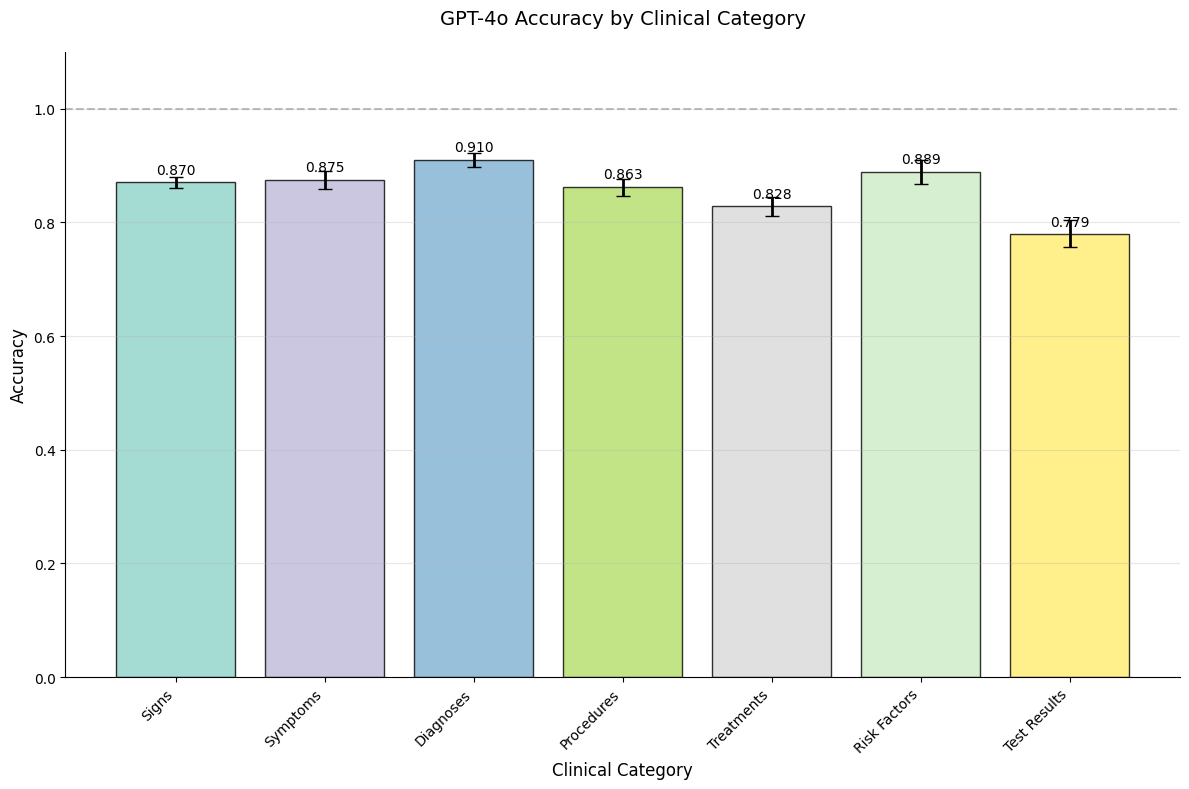

In [15]:
# Cell 9: Bar plot for accuracy across clinical categories
def plot_accuracy_by_category(category_metrics):
    """Create a bar plot showing accuracy across clinical categories"""

    # Define the desired order for categories
    category_order = ['signs', 'symptoms', 'diagnoses', 'procedures', 'treatments', 'risk factors', 'test results']

    # Prepare data for plotting
    available_categories = []
    accuracies = []
    lower_cis = []
    upper_cis = []

    for category in category_order:
        if category in category_metrics and 'Overall' in category_metrics[category]:
            metrics = category_metrics[category]['Overall']
            available_categories.append(category.title())
            accuracies.append(metrics['Accuracy'])
            lower_cis.append(metrics['Accuracy_CI'][0])
            upper_cis.append(metrics['Accuracy_CI'][1])

    # Calculate error bars (distance from mean to CI bounds)
    lower_errors = [acc - lower for acc, lower in zip(accuracies, lower_cis)]
    upper_errors = [upper - acc for acc, upper in zip(accuracies, upper_cis)]
    yerr = [lower_errors, upper_errors]

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Create different colors for each category
    colors = plt.cm.Set3(np.linspace(0, 1, len(available_categories)))

    # Create vertical bar plot with error bars
    bars = plt.bar(available_categories, accuracies, yerr=yerr, alpha=0.8, color=colors,
                   edgecolor='black', linewidth=1, capsize=5, error_kw={'linewidth': 2})

    # Add value labels on top of bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Clinical Category', fontsize=12)
    plt.title('GPT-4o Accuracy by Clinical Category', fontsize=14, pad=20)
    plt.ylim(0, 1.1)  # Set y-axis from 0 to 1.1 to accommodate labels
    plt.grid(True, alpha=0.3, axis='y')

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add a horizontal line at y=1.0 for reference
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('Accuracy_by_Clinical_Category_GPT4o.png', dpi=600, bbox_inches='tight')
    plt.show()

# Create the accuracy plot
plot_accuracy_by_category(category_metrics)

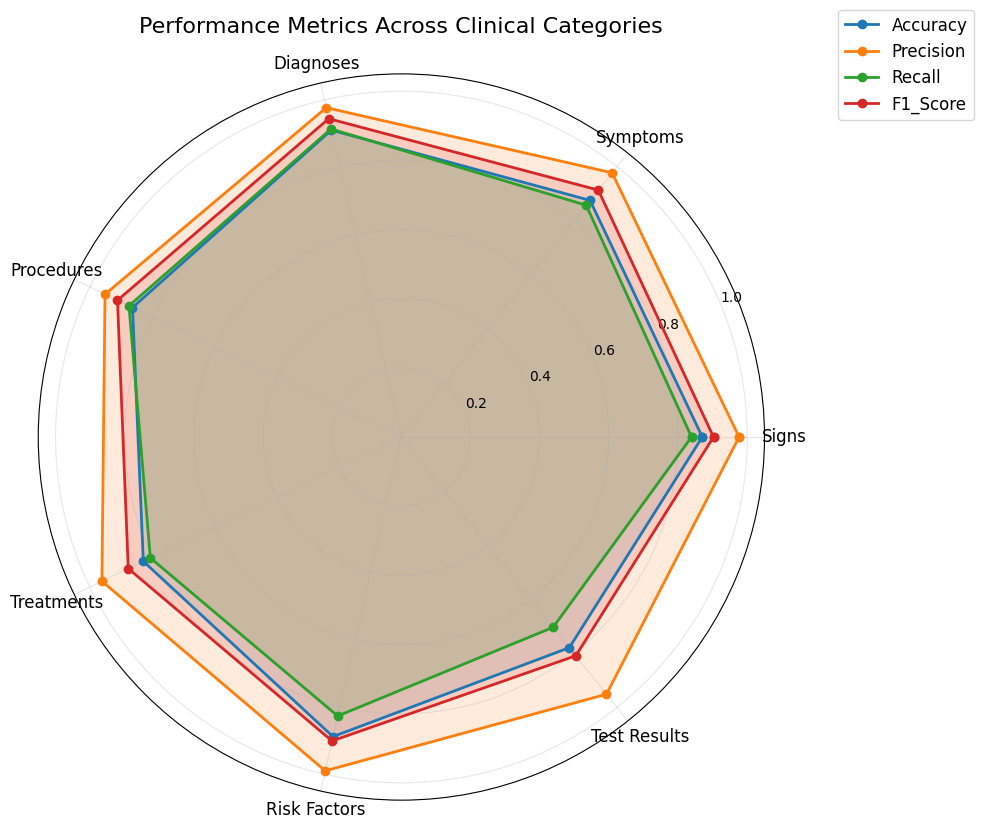

In [16]:
# Cell 14: Radar Chart for Multi-dimensional Performance Comparison
def create_radar_chart(category_metrics):
    """Create a radar chart comparing performance across clinical categories"""

    categories = ['signs', 'symptoms', 'diagnoses', 'procedures', 'treatments', 'risk factors', 'test results']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']

    # Prepare data
    available_categories = []
    metric_values = {metric: [] for metric in metrics}

    for category in categories:
        if category in category_metrics and 'Overall' in category_metrics[category]:
            available_categories.append(category.title())
            for metric in metrics:
                metric_values[metric].append(category_metrics[category]['Overall'][metric])

    # Number of categories
    num_vars = len(available_categories)

    # Compute angle for each category
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Close the plot
    for metric in metrics:
        metric_values[metric] += metric_values[metric][:1]
    angles += angles[:1]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Define colors for each metric
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Plot each metric
    for idx, (metric, values) in enumerate(metric_values.items()):
        ax.plot(angles, values, 'o-', linewidth=2, label=metric, color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])

    # Set category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(available_categories, size=12)

    # Set y-axis limits and labels
    ax.set_ylim(0, 1.05)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
    ax.grid(True, alpha=0.3)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)

    plt.title('Performance Metrics Across Clinical Categories', size=16, pad=30)
    plt.tight_layout()
    plt.savefig('Radar_Chart_Performance_GPT4o.png', dpi=600, bbox_inches='tight')
    plt.show()

# Create radar chart
create_radar_chart(category_metrics)

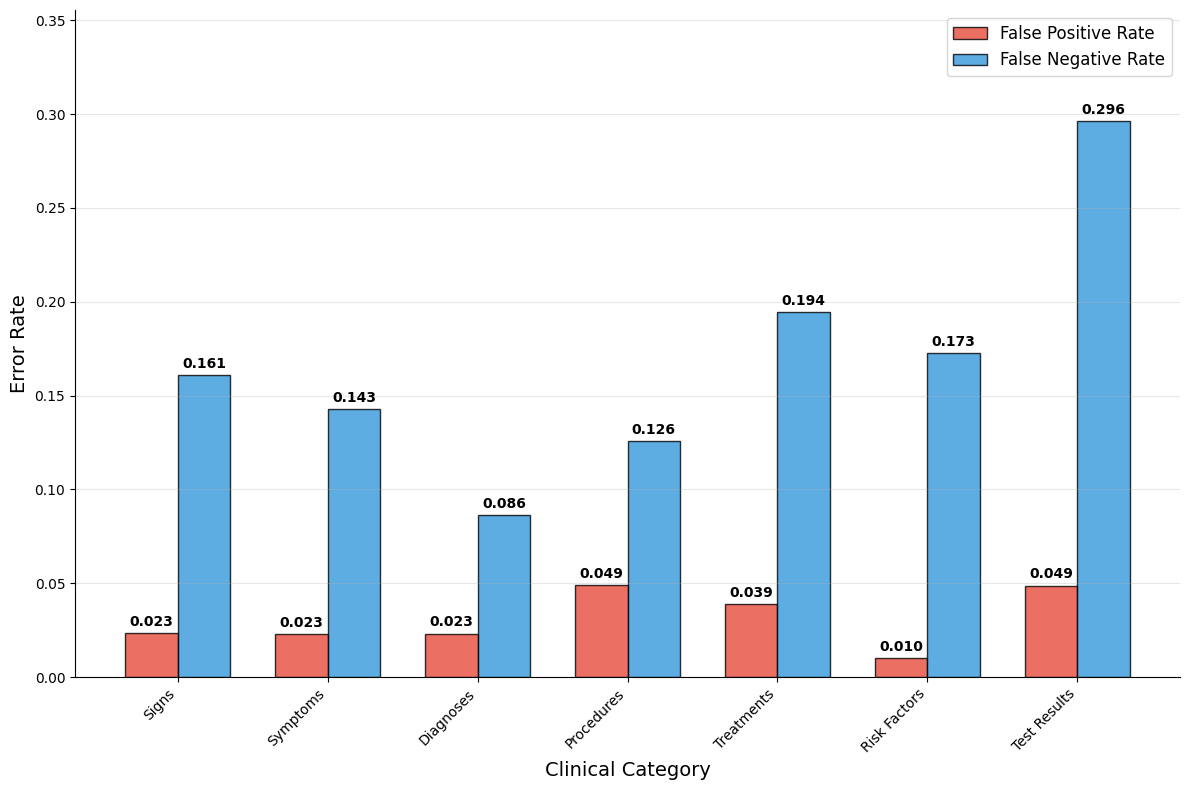

Error Rate Summary:
Signs           - FP Rate: 0.023, FN Rate: 0.161
Symptoms        - FP Rate: 0.023, FN Rate: 0.143
Diagnoses       - FP Rate: 0.023, FN Rate: 0.086
Procedures      - FP Rate: 0.049, FN Rate: 0.126
Treatments      - FP Rate: 0.039, FN Rate: 0.194
Risk Factors    - FP Rate: 0.010, FN Rate: 0.173
Test Results    - FP Rate: 0.049, FN Rate: 0.296


In [17]:
# Cell 17: Error Rates by Clinical Category (Separate Plot)
def create_error_rates_plot(category_metrics):
    """Create a bar plot showing error rates by clinical category"""

    fig, ax = plt.subplots(figsize=(12, 8))

    # Prepare data
    categories = ['signs', 'symptoms', 'diagnoses', 'procedures', 'treatments', 'risk factors', 'test results']
    available_cats = [cat for cat in categories if cat in category_metrics and 'Overall' in category_metrics[cat]]

    fp_rates = []
    fn_rates = []
    cat_labels = []

    for cat in available_cats:
        metrics = category_metrics[cat]['Overall']
        total_predictions = metrics['TP'] + metrics['FP']
        total_actual = metrics['TP'] + metrics['FN']

        fp_rate = metrics['FP'] / total_predictions if total_predictions > 0 else 0
        fn_rate = metrics['FN'] / total_actual if total_actual > 0 else 0

        fp_rates.append(fp_rate)
        fn_rates.append(fn_rate)
        cat_labels.append(cat.title())

    x = np.arange(len(cat_labels))
    width = 0.35

    # Create bars
    bars1 = ax.bar(x - width/2, fp_rates, width, label='False Positive Rate',
                    color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1)
    bars2 = ax.bar(x + width/2, fn_rates, width, label='False Negative Rate',
                    color='#3498db', alpha=0.8, edgecolor='black', linewidth=1)

    # Customize plot
    ax.set_xlabel('Clinical Category', fontsize=14)
    ax.set_ylabel('Error Rate', fontsize=14)
    #ax.set_title('Error Rates by Clinical Category', fontsize=16, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(cat_labels, rotation=45, ha='right')
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(max(fp_rates), max(fn_rates)) * 1.2)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only label non-zero bars
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('Error_Rates_by_Category_GPT4o.png', dpi=600, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("Error Rate Summary:")
    print("=" * 50)
    for i, cat in enumerate(cat_labels):
        print(f"{cat:15} - FP Rate: {fp_rates[i]:.3f}, FN Rate: {fn_rates[i]:.3f}")

# Create error rates plot
create_error_rates_plot(category_metrics)

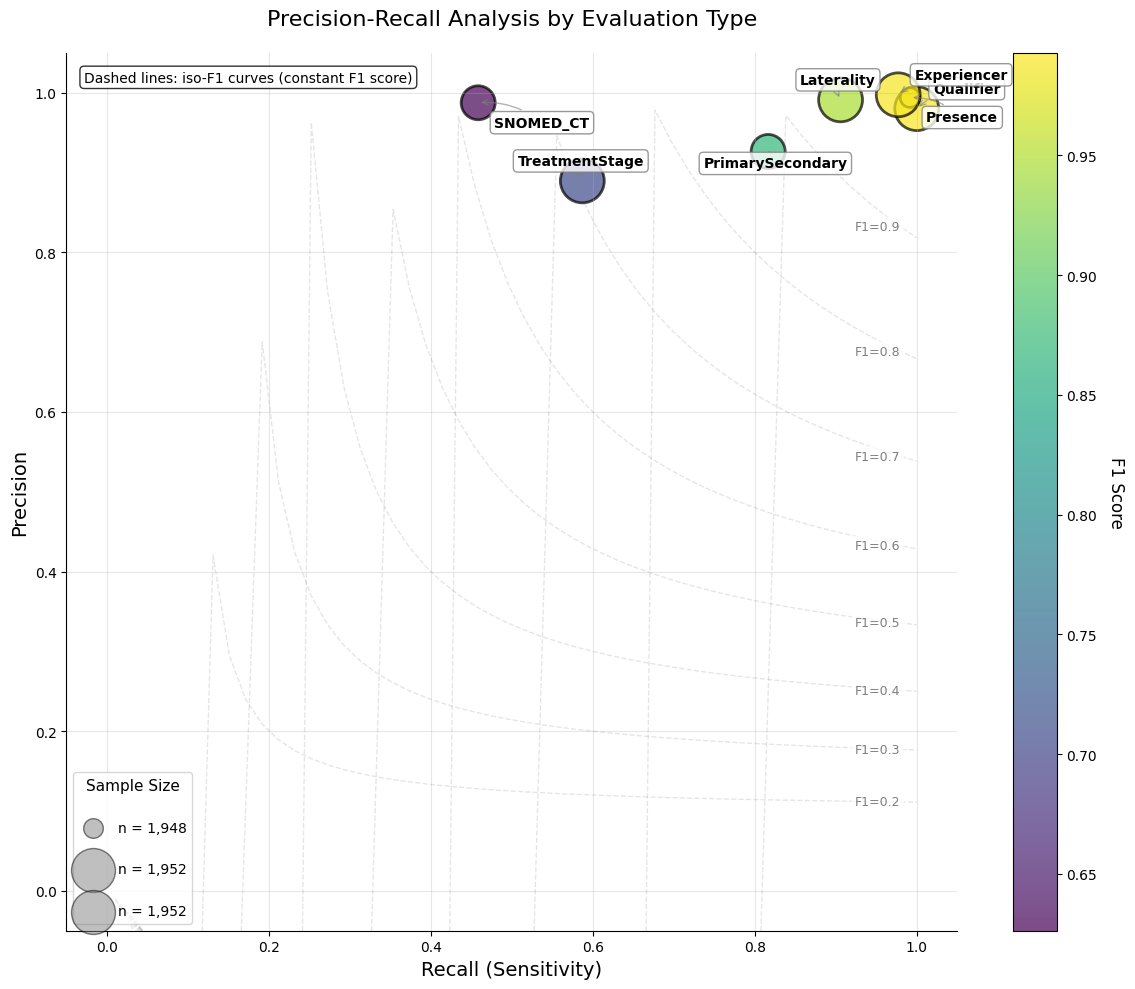


Precision-Recall Summary by Evaluation Type:
Evaluation Type       Precision     Recall   F1 Score  Sample Size
----------------------------------------------------------------------
Qualifier                 0.980      1.000      0.990        1,952
Laterality                0.991      0.906      0.947        1,952
Presence                  0.994      0.992      0.993        1,948
PrimarySecondary          0.926      0.817      0.868        1,950
Experiencer               0.997      0.977      0.987        1,952
TreatmentStage            0.889      0.587      0.707        1,952
SNOMED_CT                 0.987      0.459      0.626        1,950


In [18]:
# Cell 18: Precision-Recall Plot with Smart Label Placement
def create_precision_recall_plot(eval_type_metrics):
    """Create an improved precision-recall scatter plot with better label placement"""

    fig, ax = plt.subplots(figsize=(12, 10))

    # Prepare data
    eval_types = []
    precisions = []
    recalls = []
    f1_scores = []
    sample_sizes = []

    for eval_type, metrics in eval_type_metrics.items():
        eval_types.append(eval_type.replace('_Evaluation', ''))
        precisions.append(metrics['Precision'])
        recalls.append(metrics['Recall'])
        f1_scores.append(metrics['F1_Score'])
        sample_sizes.append(metrics['Total'])

    # Convert to numpy arrays
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)
    sample_sizes = np.array(sample_sizes)

    # Normalize sample sizes for marker sizing
    sizes_normalized = 200 + (sample_sizes - sample_sizes.min()) / (sample_sizes.max() - sample_sizes.min()) * 800

    # Create scatter plot
    scatter = ax.scatter(recalls, precisions, s=sizes_normalized, alpha=0.7,
                        c=f1_scores, cmap='viridis', edgecolors='black', linewidth=2)

    # Add iso-F1 curves with lighter style
    f_scores = np.linspace(0.2, 0.9, num=8)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y <= 1], y[y <= 1], '--', alpha=0.2, color='gray', linewidth=1)
        # Label F1 curves on the right side
        x_pos = 0.98
        y_pos = f_score * x_pos / (2 * x_pos - f_score)
        if y_pos <= 1:
            ax.text(x_pos, y_pos, f'F1={f_score:.1f}', fontsize=9, alpha=0.5,
                   ha='right', va='center', bbox=dict(boxstyle='round,pad=0.3',
                   facecolor='white', alpha=0.7, edgecolor='none'))

    # Smart label placement using adjustText or manual adjustment
    from matplotlib.patches import FancyBboxPatch

    # Sort by recall to help with label placement
    sorted_indices = np.argsort(recalls)

    # Place labels with manual adjustments to avoid overlap
    label_offsets = {
        'Qualifier': (0.02, 0.02),
        'Laterality': (-0.05, 0.02),
        'Presence': (0.02, -0.03),
        'PrimarySecondary': (-0.08, -0.02),
        'Experiencer': (0.02, 0.02),
        'TreatmentStage': (-0.08, 0.02),
        'SNOMED_CT': (0.02, -0.03)
    }

    for i, txt in enumerate(eval_types):
        # Get custom offset or default
        offset = label_offsets.get(txt, (0.02, 0.02))

        # Create text box with background
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor='white',
                         edgecolor='gray', alpha=0.8)

        ax.annotate(txt,
                   xy=(recalls[i], precisions[i]),
                   xytext=(recalls[i] + offset[0], precisions[i] + offset[1]),
                   fontsize=10, fontweight='bold',
                   bbox=bbox_props,
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2',
                                 color='gray', alpha=0.6))

    # Customize plot
    ax.set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('Precision-Recall Analysis by Evaluation Type', fontsize=16, pad=20)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('F1 Score', rotation=270, labelpad=20, fontsize=12)

    # Create custom legend for bubble sizes
    # Sample sizes for legend
    size_examples = [sample_sizes.min(),
                    np.percentile(sample_sizes, 50),
                    sample_sizes.max()]
    size_examples_norm = [200 + (s - sample_sizes.min()) / (sample_sizes.max() - sample_sizes.min()) * 800
                         for s in size_examples]

    # Add size legend
    for i, (size, size_norm) in enumerate(zip(size_examples, size_examples_norm)):
        ax.scatter([], [], s=size_norm, c='gray', alpha=0.5, edgecolors='black',
                  linewidth=1, label=f'n = {int(size):,}')

    size_legend = ax.legend(scatterpoints=1, frameon=True, labelspacing=2,
                           title='Sample Size', loc='lower left', fontsize=10)
    size_legend.get_title().set_fontsize(11)

    # Add text explanation of iso-F1 curves
    ax.text(0.02, 0.98, 'Dashed lines: iso-F1 curves (constant F1 score)',
           transform=ax.transAxes, verticalalignment='top', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('Precision_Recall_by_Evaluation_Type_GPT4o.png', dpi=600, bbox_inches='tight')
    plt.show()

    # Print summary table
    print("\nPrecision-Recall Summary by Evaluation Type:")
    print("=" * 70)
    print(f"{'Evaluation Type':20} {'Precision':>10} {'Recall':>10} {'F1 Score':>10} {'Sample Size':>12}")
    print("-" * 70)
    for i in range(len(eval_types)):
        print(f"{eval_types[i]:20} {precisions[i]:>10.3f} {recalls[i]:>10.3f} "
              f"{f1_scores[i]:>10.3f} {sample_sizes[i]:>12,}")

# Create improved precision-recall plot
create_precision_recall_plot(eval_type_metrics)

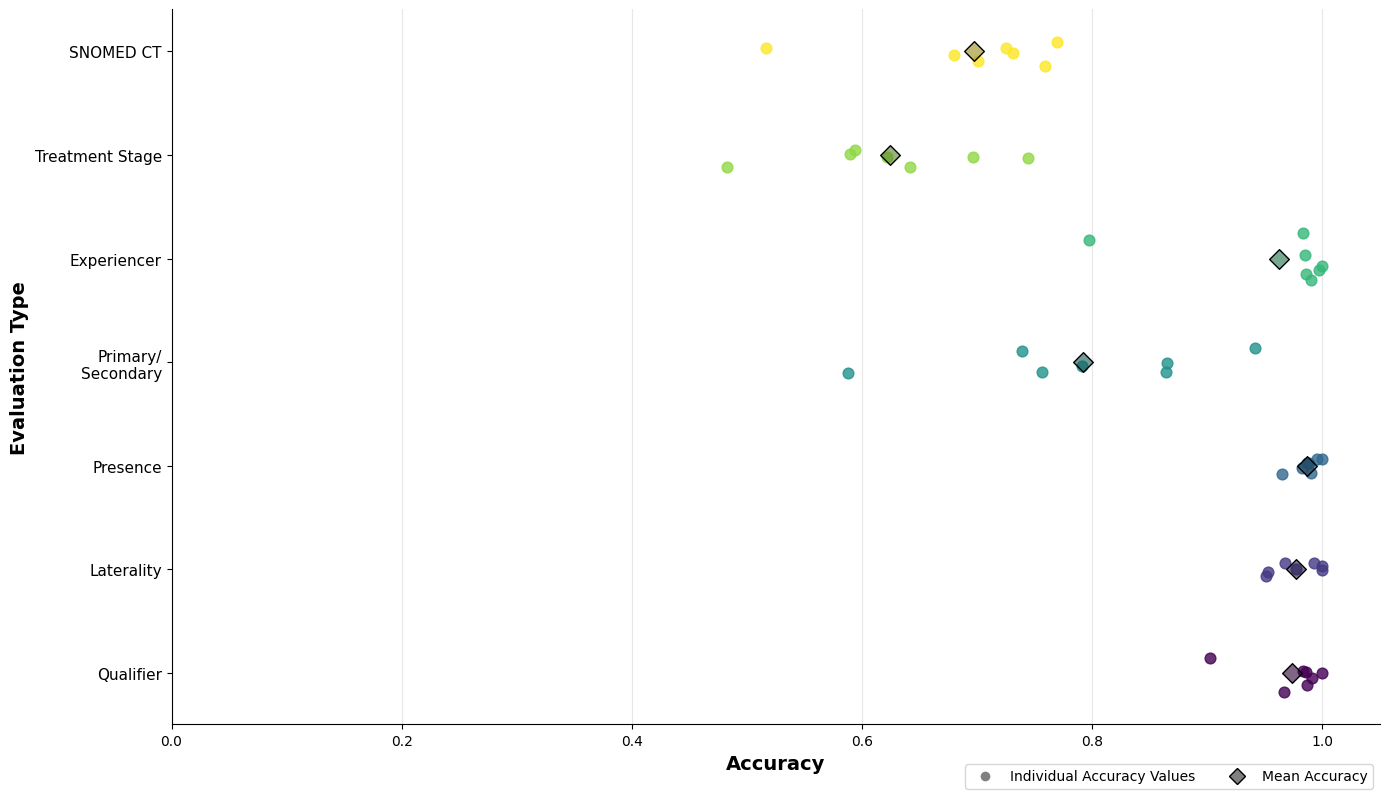

In [49]:
# Cell 21: Performance Range Plot - By Evaluation Type
def create_performance_range_by_eval_type(category_metrics):
    """Create performance swarm plot for each evaluation type across clinical categories"""

    fig, ax = plt.subplots(figsize=(14, 8))

    # Label mapping for cleaner display
    label_mapping = {
        'SNOMED_CT_Evaluation': 'SNOMED CT',
        'TreatmentStage_Evaluation': 'Treatment Stage',
        'PrimarySecondary_Evaluation': 'Primary/\nSecondary',
        'Qualifier_Evaluation': 'Qualifier',
        'Laterality_Evaluation': 'Laterality',
        'Presence_Evaluation': 'Presence',
        'Experiencer_Evaluation': 'Experiencer'
    }

    # Collect data for each evaluation type
    plot_data = []
    categories = ['signs', 'symptoms', 'diagnoses', 'procedures', 'treatments', 'risk factors', 'test results']

    for eval_type in EVAL_COLUMNS:
        # Get accuracies across all categories for this eval type
        for cat in categories:
            if cat in category_metrics and eval_type in category_metrics[cat]:
                display_name = label_mapping.get(eval_type, eval_type.replace('_Evaluation', ''))
                plot_data.append({
                    'Evaluation_Type': display_name,
                    'Accuracy': category_metrics[cat][eval_type]['Accuracy'],
                    'Category': cat
                })

    # Convert to DataFrame for easier plotting
    import pandas as pd
    df = pd.DataFrame(plot_data)

    if not df.empty:
        # Get unique evaluation types and create color palette
        eval_types = df['Evaluation_Type'].unique()
        # Use a different color palette for evaluation types (viridis)
        colors = plt.cm.viridis(np.linspace(0, 1, len(eval_types)))

        # Create swarm plot
        for i, eval_type in enumerate(eval_types):
            eval_data = df[df['Evaluation_Type'] == eval_type]['Accuracy']

            # Create swarm-like distribution (add small random jitter for y-position)
            y_positions = np.full(len(eval_data), i) + np.random.normal(0, 0.1, len(eval_data))

            # Plot points
            ax.scatter(eval_data, y_positions, color=colors[i], alpha=0.8, s=60, zorder=3)

            # Add diamond marker at mean with darker shade of same color
            mean_val = eval_data.mean()
            darker_color = colors[i] * 0.6  # Make color darker
            ax.scatter(mean_val, i, marker='D', color=darker_color, s=100,
                      edgecolor='black', linewidth=1, zorder=4)

    ax.set_yticks(range(len(eval_types)))
    ax.set_yticklabels(eval_types, fontsize=11)
    ax.set_xlabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_ylabel('Evaluation Type', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_xlim(0, 1.05)

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8,
               label='Individual Accuracy Values', linestyle='None'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='gray', markersize=8,
               markeredgecolor='black', label='Mean Accuracy', linestyle='None')
    ]
    ax.legend(handles=legend_elements, loc='lower right', frameon=True, fancybox=True, ncol=2,
              bbox_to_anchor=(1, -0.1))

    plt.tight_layout()
    plt.savefig('Performance_Range_by_Evaluation_Type_GPT4o.png', dpi=600, bbox_inches='tight')
    plt.show()

# Create the plot
create_performance_range_by_eval_type(category_metrics)

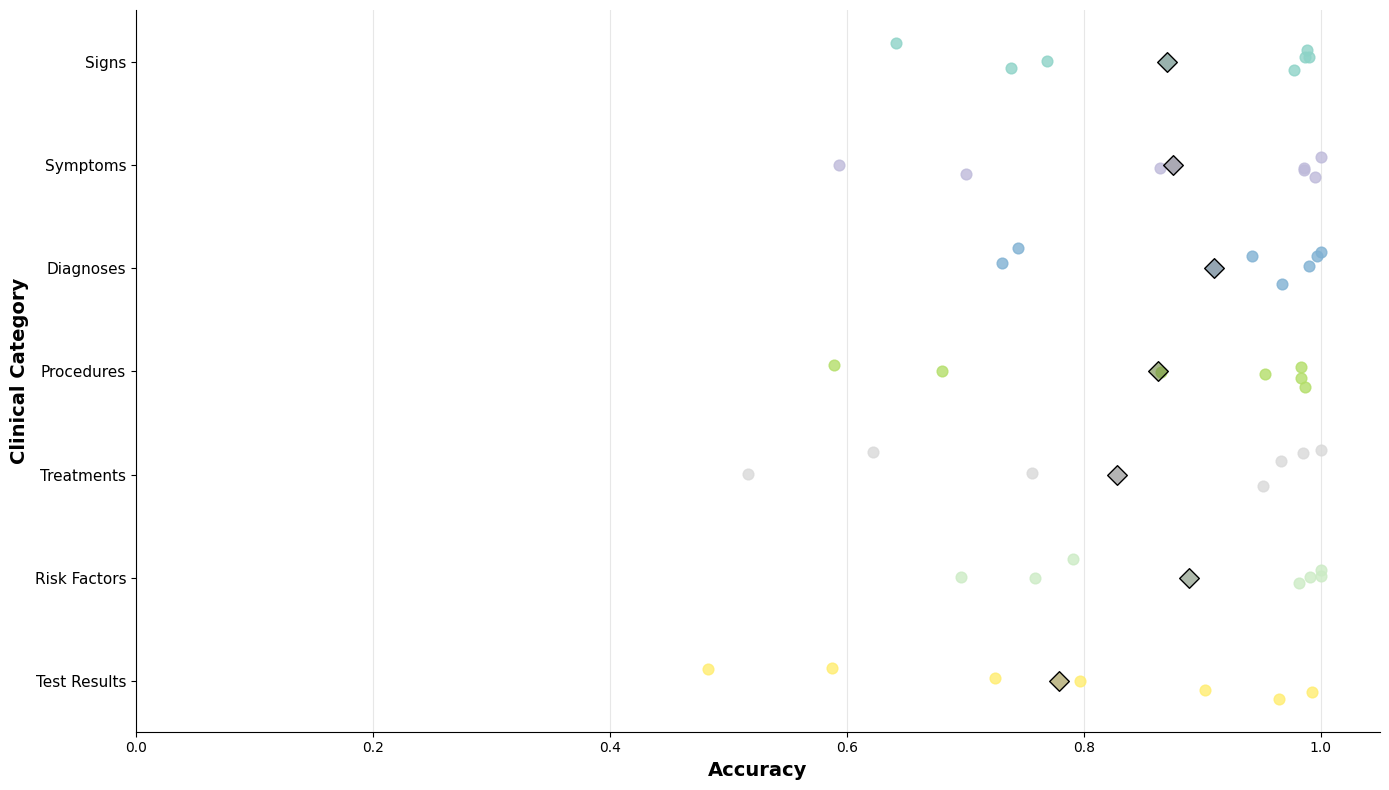

In [50]:
# Cell 22: Performance Range Plot - By Clinical Category
def create_performance_range_by_category(category_metrics):
    """Create performance swarm plot for each clinical category across evaluation types"""

    fig, ax = plt.subplots(figsize=(14, 8))

    # Label mapping for cleaner display
    eval_label_mapping = {
        'SNOMED_CT_Evaluation': 'SNOMED CT',
        'TreatmentStage_Evaluation': 'Treatment Stage',
        'PrimarySecondary_Evaluation': 'Primary/Secondary',
        'Qualifier_Evaluation': 'Qualifier',
        'Laterality_Evaluation': 'Laterality',
        'Presence_Evaluation': 'Presence',
        'Experiencer_Evaluation': 'Experiencer'
    }

    # Define the desired order for categories (same as other plots)
    category_order = ['signs', 'symptoms', 'diagnoses', 'procedures', 'treatments', 'risk factors', 'test results']

    # Categories to analyze with proper display names
    category_display_names = {
        'signs': 'Signs',
        'symptoms': 'Symptoms',
        'diagnoses': 'Diagnoses',
        'procedures': 'Procedures',
        'treatments': 'Treatments',
        'risk factors': 'Risk Factors',
        'test results': 'Test Results'
    }

    # Collect data for each clinical category
    plot_data = []
    available_categories = []

    for cat in category_order:
        if cat in category_metrics:
            available_categories.append(cat)
            # Get accuracies across all evaluation types for this category
            for eval_type in EVAL_COLUMNS:
                if eval_type in category_metrics[cat]:
                    plot_data.append({
                        'Category': category_display_names[cat],
                        'Accuracy': category_metrics[cat][eval_type]['Accuracy'],
                        'Evaluation_Type': eval_label_mapping.get(eval_type, eval_type.replace('_Evaluation', ''))
                    })

    # Convert to DataFrame for easier plotting
    import pandas as pd
    df = pd.DataFrame(plot_data)

    if not df.empty:
        # Create different colors for each category (same scheme as other plots)
        colors = plt.cm.Set3(np.linspace(0, 1, len(available_categories)))
        category_to_color = {category_display_names[cat]: colors[i] for i, cat in enumerate(available_categories)}

        # Get unique categories in the order they appear
        categories = [category_display_names[cat] for cat in available_categories if cat in category_metrics]

        # Reverse the order so signs are at top and test results at bottom
        categories_reversed = categories[::-1]

        # Create swarm plot
        for i, category in enumerate(categories_reversed):
            cat_data = df[df['Category'] == category]['Accuracy']

            # Create swarm-like distribution (add small random jitter for y-position)
            y_positions = np.full(len(cat_data), i) + np.random.normal(0, 0.1, len(cat_data))

            # Plot points with category-specific color
            ax.scatter(cat_data, y_positions, color=category_to_color[category],
                      alpha=0.8, s=60, zorder=3)

            # Add diamond marker at mean with darker shade of same color
            mean_val = cat_data.mean()
            darker_color = category_to_color[category] * 0.6  # Make color darker
            ax.scatter(mean_val, i, marker='D', color=darker_color, s=100,
                      edgecolor='black', linewidth=1, zorder=4)

    ax.set_yticks(range(len(categories_reversed)))
    ax.set_yticklabels(categories_reversed, fontsize=11)
    ax.set_xlabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_ylabel('Clinical Category', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_xlim(0, 1.05)

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8,
               label='Individual Accuracy Values', linestyle='None'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='gray', markersize=8,
               markeredgecolor='black', label='Mean Accuracy', linestyle='None')
    ]
    #ax.legend(handles=legend_elements, loc='lower right', frameon=True, fancybox=True, bbox_to_anchor=(1.3, 1))

    # Set consistent positioning for subplot alignment
    plt.tight_layout()
    plt.savefig('Performance_Range_by_Clinical_Category_GPT4o.png', dpi=600, bbox_inches='tight')
    plt.show()

# Create the plot
create_performance_range_by_category(category_metrics)

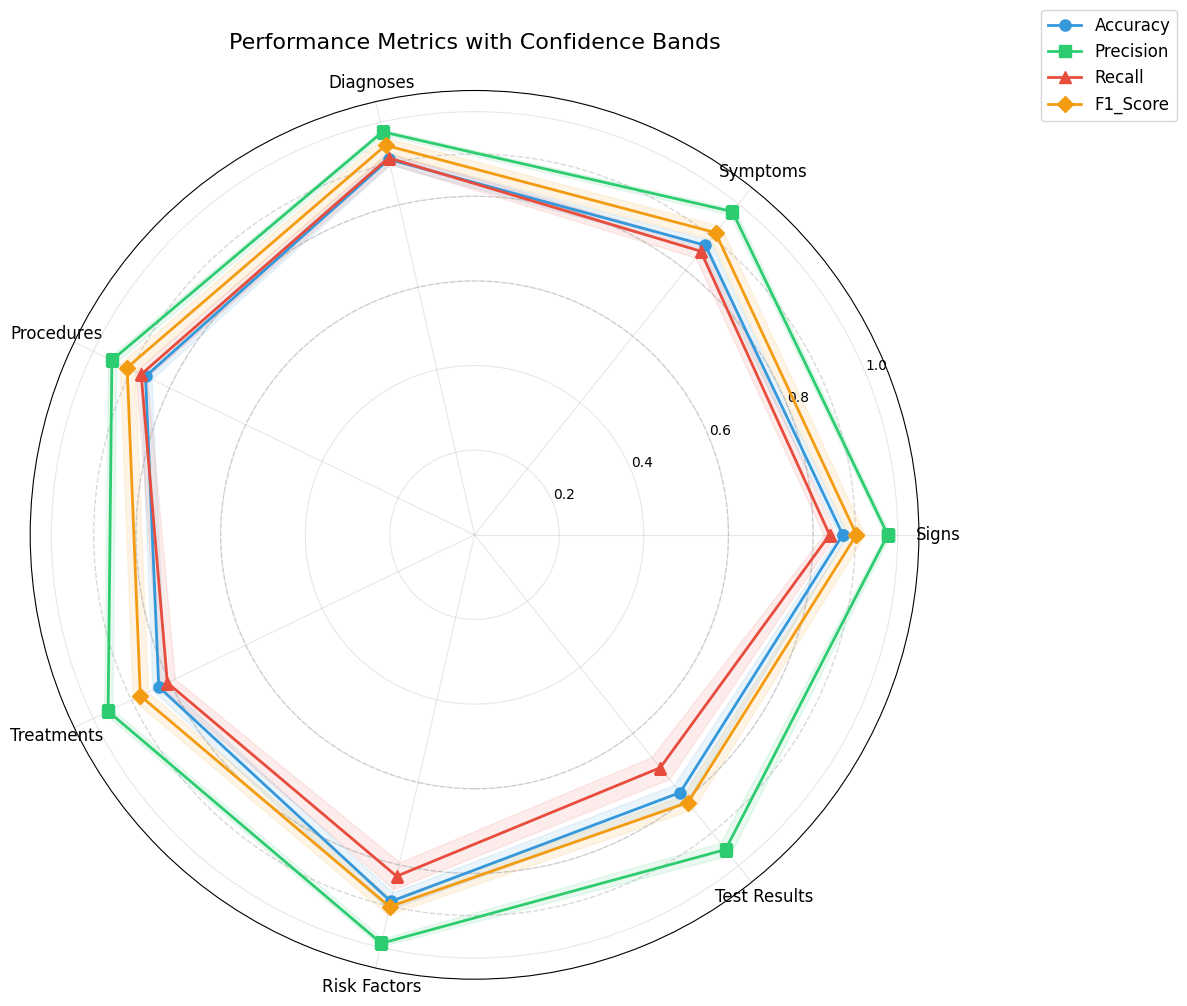

In [64]:
# Cell 23: Performance Spider Plot with Confidence Bands
def create_performance_spider_with_confidence(category_metrics):
    """Create a spider/radar plot with confidence bands"""

    from matplotlib.patches import Circle
    import matplotlib.patches as mpatches

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

    # Prepare data
    categories = ['signs', 'symptoms', 'diagnoses', 'procedures', 'treatments', 'risk factors', 'test results']
    available_cats = [cat for cat in categories if cat in category_metrics and 'Overall' in category_metrics[cat]]

    # Metrics to plot
    metrics_to_plot = {
        'Accuracy': {'color': '#3498db', 'marker': 'o'},
        'Precision': {'color': '#2ecc71', 'marker': 's'},
        'Recall': {'color': '#e74c3c', 'marker': '^'},
        'F1_Score': {'color': '#f39c12', 'marker': 'D'}
    }

    # Calculate angles
    angles = np.linspace(0, 2 * np.pi, len(available_cats), endpoint=False).tolist()

    # Plot each metric with confidence bands
    for metric_name, style in metrics_to_plot.items():
        values = []
        lower_bounds = []
        upper_bounds = []

        for cat in available_cats:
            metrics = category_metrics[cat]['Overall']
            values.append(metrics[metric_name])
            if f'{metric_name}_CI' in metrics:
                lower_bounds.append(metrics[f'{metric_name}_CI'][0])
                upper_bounds.append(metrics[f'{metric_name}_CI'][1])
            else:
                # If no CI, use value +/- small amount for visualization
                lower_bounds.append(metrics[metric_name] - 0.02)
                upper_bounds.append(metrics[metric_name] + 0.02)

        # Close the plot
        values += values[:1]
        lower_bounds += lower_bounds[:1]
        upper_bounds += upper_bounds[:1]
        angles_plot = angles + angles[:1]

        # Plot confidence band
        ax.fill_between(angles_plot, lower_bounds, upper_bounds,
                       alpha=0.1, color=style['color'])

        # Plot main line
        ax.plot(angles_plot, values, 'o-', linewidth=2,
                label=metric_name, color=style['color'],
                marker=style['marker'], markersize=8)

    # Customize plot
    ax.set_xticks(angles)
    ax.set_xticklabels([cat.title() for cat in available_cats], size=12)
    ax.set_ylim(0, 1.05)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(True, alpha=0.3)

    # Add reference circles
    for y in [0.6, 0.8, 0.9]:
        circle = plt.Circle((0, 0), y, transform=ax.transData._b,
                           fill=False, edgecolor='gray',
                           linestyle='--', alpha=0.3, linewidth=1)
        ax.add_patch(circle)

    # Legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
    plt.title('Performance Metrics with Confidence Bands', size=16, pad=30)

    plt.tight_layout()
    plt.savefig('Performance_Spider_Confidence_GPT4o.png', dpi=600, bbox_inches='tight')
    plt.show()

# Create spider plot with confidence
create_performance_spider_with_confidence(category_metrics)